### Import librairies

In [1]:
# Main libraries
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager

# Libraries for vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Library for ignoring warnings
import warnings
warnings.filterwarnings("ignore")

### Define path for each dataset

In [2]:
# Define paths for each dataset
application_test_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv"
application_train_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv"
bureau_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv"
bureau_balance_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv"
credit_card_balance_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv"
HomeCredit_columns_description_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/HomeCredit_columns_description.csv"
installments_payments_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv"
POS_CASH_balance_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv"
previous_application_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv"
sample_submission_path = "C:/Users/33624/Projet+Mise+en+prod+-+home-credit-default-risk/sample_submission.csv"

# Pre-processing and Feature engineering functions

### Kernel 'LightGBM with Simple Features' is used as base for feature engineering

Most features are created by applying min, max, mean, sum and var functions to grouped tables. 

Little feature selection is done and overfitting might be a problem since many features are related.  

The following key ideas were used:
- Divide or subtract important features to get rates (like annuity and income)
- In Bureau Data: create specific features for Active credits and Closed credits
- In Previous Applications: create specific features for Approved and Refused applications
- Modularity: one function for each table (except bureau_balance and application_test)
- One-hot encoding for categorical features

All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).

In [3]:
# Timer and one-hot-encoder functions

@contextmanager
# Timer function
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    
    """"
    Parameters
    ----------
    df : pandas dataframe 
        dataframe containing categorical columns/features
    nan_as_category : Bool
        if True, add a column indicating NaNs when one_hot_encoding
        
    Returns
    -------
    df : pandas dataframe
        one_hot_encoded dataframe
    new_columns : list
        new list of all the columns in the above new dataframe
    """
    
    # Create the list of all the columns
    original_columns = list(df.columns)
    # Create the list of categorical_columns for further one_hot_encoding
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    # One_hot_encoding
    df = pd.get_dummies(df, 
                        columns = categorical_columns, # apply one_hot_encoder to categorical columns only 
                        dummy_na = nan_as_category, # if True, add a column to indicate NaNs
                        drop_first = False) # if True, remove the first categorical level
    # Create the new list of all the columns after one_hot_encoding categorical features
    new_columns = [c for c in df.columns if c not in original_columns]
    
    return df, new_columns


In [4]:
# define functions to pre-process, feature engineer and merge bureau & bureau_balance datasets
def bureau_and_balance(nan_as_category = True):
    
    """
    Parameters
    ----------
    sep : string
        Delimiter used in the csv files
    nan_as_category : Bool
        if True, add a column indicating NaNs when one_hot_encoding
    
    Returns
    -------
    bureau_agg : pandas dataframe
        New dataframe created by merging bureau, bureau_balance and aggregated dataframes, 
        one-hot encoding
    """
    
    # Read data
    bureau = pd.read_csv(bureau_path, sep = ',')
    bb = pd.read_csv(bureau_balance_path, sep = ',')
    
    # Categorical features with One-Hot encode
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    # Create aggregated dataframe with new columns : min, max and size for MONTHS_BALANCE and mean for bb_cat features
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    # Keep just one title by column
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    # Merge bureau and bb_agg
    bureau = bureau.join(bb_agg, how = 'left', on = 'SK_ID_BUREAU')
    # Drop column 'SK_ID_BUREAU'
    bureau.drop(['SK_ID_BUREAU'], axis = 1, inplace = True)
    # Delete bb and bb_agg (Just keep bureau after aggregation)
    del bb, bb_agg
    ### gc.collect() ?
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    # Create aggregated dataframe with new columns: mean for bb_cat and bureau_cat features 
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    # Keep just one title by column
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    # Create aggregated dataframe with new columns : min, max, var, mean, sum for numeric features
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    # Keep just one title by column
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    # Merge bureau_agg and active_agg
    bureau_agg = bureau_agg.merge(active_agg, how='left', on='SK_ID_CURR')
    # Delete active and active_agg (keep only bureau_agg)
    del active, active_agg
    ### gc.collect() ?
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    # Create aggregated dataframe with new columns : min, max, var, mean, sum for numeric features
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    # Keep just one title by column
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    # Merge bureau_agg and closed_agg
    bureau_agg = bureau_agg.merge(closed_agg, how='left', on='SK_ID_CURR')
    # Delete closed, closed_agg and bureau (keep only bureau_agg)
    del closed, closed_agg, bureau
    ### gc.collect() ?
    return bureau_agg

In [5]:
# Preprocess and feature engineer application_train.csv and application_test.csv
def application_train_test(nan_as_category = False):
    
    """
    Parameters
    ----------
    sep : string
        Delimiter used in the csv files
    nan_as_category : Bool
        if True, add a column indicating NaNs when one_hot_encoding
    
    Returns
    -------
    df : pandas dataframe
        New dataframe created by merging train and test dataframes, binary and one-hot encoding,
        creating new simple features from AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, etc...
    """
    
    # Read data 
    df = pd.read_csv(application_train_path, sep = ',')
    test_df = pd.read_csv(application_test_path, sep = ',')
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    # merge application_train and application_test
    df = df.append(test_df).reset_index()
    # Remove 4 applications with XNA CODE_GENDER (in train set and not in test set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    ### gc.collect() : intérêt ???
    return df

In [6]:
# Preprocess and feature engineer previous_applications.csv
def previous_applications(nan_as_category = True):

    """
    Parameters
    ----------
    nan_as_category : Bool
        if True, add a column indicating NaNs when one_hot_encoding
    
    Returns
    -------
    prev_agg : pandas dataframe
        New dataframe created by cleaning previous_application_path, 
        hot_hot_encoding categorical features, aggregating by SK_ID_CURR
    """
    
    # Read data
    prev = pd.read_csv(previous_application_path, sep = ',')
    
    # Categorical features with One-Hot encode
    prev, cat_cols = one_hot_encoder(prev, nan_as_category = True)
    
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace = True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace = True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace = True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace = True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace = True)
    
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum']
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    # Create aggregated dataframe with new columns: mean for cat_cols and min, max, mean, sum for numeric features
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    # Keep just one title by column
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    # Delete refused, refused_agg, approved, approved_agg, prev (keep only prev_agg)
    del refused, refused_agg, approved, approved_agg, prev
    ### gc.collect() ?
    return prev_agg

In [7]:
# Preprocess and feature engineer POS_CASH_balance.csv
def pos_cash(nan_as_category = True):
    
    """
    Parameters
    ----------
    nan_as_category : Bool
        if True, add a column indicating NaNs when one_hot_encoding
    
    Returns
    -------
    pos_agg : pandas dataframe
        New dataframe created by cleaning previous_application_path, 
        one_hot_encoding categorical features, aggregating by SK_ID_CURR
    """
    
    # Read data
    pos = pd.read_csv(POS_CASH_balance_path, sep = ',')
    
    # Categorical features with One-Hot encode
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    
    # numeric features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    # categorical features
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    # Create aggregated dataframe with new columns: mean for cat_cols and max, mean, size for numeric features
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    # Delete pos (keep only pos_agg)
    del pos
    ### gc.collect() ??
    return pos_agg

In [8]:
# Preprocess and feature engineer installments_payments.csv
def installments_payments(nan_as_category = True):
    
    """
    Parameters
    ----------
    nan_as_category : Bool
        if True, add a column indicating NaNs when one_hot_encoding
    
    Returns
    -------
    ins_agg : pandas dataframe
        New dataframe created by cleaning previous_application_path, 
        one_hot_encoding categorical features, aggregating by SK_ID_CURR
    """
    
    # Read data
    ins = pd.read_csv(installments_payments_path, sep = ',')
    
    # Categorical features with One-Hot encode
    ins, cat_cols = one_hot_encoder(ins, nan_as_category = True)
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Numeric Features
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    # Categorical features
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    # Perform aggregations
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    # Delete ins (Keep only ins_agg)
    del ins
    ### gc.collect() ???
    return ins_agg

In [9]:
# Preprocess and feature engineer credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    
    """
    Parameters
    ----------
    nan_as_category : Bool
        if True, add a column indicating NaNs when one_hot_encoding
    
    Returns
    -------
    cc_agg : pandas dataframe
        New dataframe created by cleaning previous_application_path, 
        one_hot_encoding categorical features, aggregating by SK_ID_CURR
    """
    
    # Read data
    cc = pd.read_csv(credit_card_balance_path, sep = ',')
    
    # Categorical features with One-Hot encode
    cc, cat_cols = one_hot_encoder(cc, nan_as_category = True)
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    # Delete cc (keep just cc_agg)
    del cc
    ### gc.collect() ???
    return cc_agg

In [10]:
# Define a function to run all the above functions
def main(debug = False):
    
    """
    Parameters
    ----------
    debug : Bool
    
    Returns
    -------
    df : pandas dataframe
        Final dataframe created by cleaning, preparing and merging
        all the dataframes
    """
    
    df = application_train_test()
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance()
        print("Bureau df shape:", bureau.shape)
        df = df.merge(bureau, how = 'left', on = 'SK_ID_CURR')
        del bureau
    with timer("Process previous_applications"):
        prev = previous_applications()
        print("Previous applications df shape:", prev.shape)
        df = df.merge(prev, how = 'left', on = 'SK_ID_CURR')
        del prev
    with timer("Process POS-CASH balance"):
        pos = pos_cash()
        print("Pos-cash balance df shape:", pos.shape)
        df = df.merge(pos, how = 'left', on = 'SK_ID_CURR')
        del pos
    with timer("Process installments payments"):
        ins = installments_payments()
        print("Installments payments df shape:", ins.shape)
        df = df.merge(ins, how = 'left', on = 'SK_ID_CURR')
        del ins
    with timer("Process credit card balance"):
        cc = credit_card_balance()
        print("Credit card balance df shape:", cc.shape)
        df = df.merge(cc, how = 'left', on = 'SK_ID_CURR')
        del cc
    
    return df

In [11]:
# Run 'main' function in order to get pre-processed, engineered and merged dataframe 'df'
startTime = time.time()

# Run 'main'
df = main(debug = False)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
executionTime_min = executionTime / 60
print('Execution time in minutes: ' + str(executionTime_min))

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 83s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 39s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 18s
Installments payments df shape: (339587, 26)
Process installments payments - done in 32s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 28s
Execution time in seconds: 211.57960057258606
Execution time in minutes: 3.526326676209768


In [12]:
# remove special characters in df feature names
df.columns = df.columns.str.replace(':', '')
df.columns = df.columns.str.replace(',', '')
df.columns = df.columns.str.replace(']', '')
df.columns = df.columns.str.replace('[', '')
df.columns = df.columns.str.replace('{', '')
df.columns = df.columns.str.replace('}', '')
df.columns = df.columns.str.replace('"', '')

# Further EDA after feature engineering and merging all the datasets

In [13]:
# Code to display all the columns
def set_pandas_display_options() -> None:
    display = pd.options.display
    display.max_columns = 130
    display.max_rows = 220
    display.max_colwidth = 200
    display.width = None
set_pandas_display_options()


# Show exact values on barplots
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

        
# Create function that counts the observations in each categorical bin using bars
def graph_objects(dataframe, hue = None):
    
    if hue is not None:
        hue = hue
        
    df = dataframe.dtypes
    df.index.name = 'columns'
    df = pd.DataFrame(df, columns = ['dtype'])
    df = df.reset_index()
    df = df[df['dtype'] == 'object']
    list_objects = df['columns'].tolist()
    
    for obj in list_objects:
        plt.figure(figsize = (15,4))
        plot = sns.countplot(obj, data = dataframe, hue = hue)
        plt.xticks(rotation = 90)
        show_values(plot)

In [14]:
# Vizualise df
df

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,...,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0000,0.0250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7

In [15]:
# Replace infinite values by NaN in df
df = df.replace([np.inf, -np.inf], np.nan)

In [16]:
# Create and Vizualise train_df by selecting customer with TARGET value
train_df = df.loc[df['TARGET'].notnull()]
train_df

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,...,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.

In [17]:
# Shape of train_df
train_df.shape

(307507, 798)

In [18]:
# Save train_df as csv file
train_df.to_csv('train_df.csv', index = False)

In [25]:
# Create and Vizualise test_df by selecting customer without TARGET value
test_df = df.loc[(df['TARGET'] != 1) & (df['TARGET'] != 0)]
test_df = test_df.drop('TARGET', axis = 1)
test_df

,index,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,...,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CNT_DRAWINGS_POS_CURRENT_VAR,CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CNT_INSTALMENT_MATURE_CUM_VAR,CC_SK_DPD_MIN,CC_SK_DPD_MAX,CC_SK_DPD_MEAN,CC_SK_DPD_SUM,CC_SK_DPD_VAR,CC_SK_DPD_DEF_MIN,CC_SK_DPD_DEF_MAX,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Active_MAX,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_NAME_CONTRACT_STATUS_Active_VAR,CC_NAME_CONTRACT_STATUS_Approved_MIN,CC_NAME_CONTRACT_STATUS_Approved_MAX,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Approved_SUM,CC_NAME_CONTRACT_STATUS_Approved_VAR,CC_NAME_CONTRACT_STATUS_Completed_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Completed_SUM,CC_NAME_CONTRACT_STATUS_Completed_VAR,CC_NAME_CONTRACT_STATUS_Demand_MIN,CC_NAME_CONTRACT_STATUS_Demand_MAX,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Demand_VAR,CC_NAME_CONTRACT_STATUS_Refused_MIN,CC_NAME_CONTRACT_STATUS_Refused_MAX,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Refused_SUM,CC_NAME_CONTRACT_STATUS_Refused_VAR,CC_NAME_CONTRACT_STATUS_Sent proposal_MIN,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
307507,0,100001,1,0,0,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329.0,-5170.0,-812,NaN,1,1,0,1,0,1,2.0,2,2,18,0,0,0,0,0,0,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,1,100005,0,0,0,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469.0,-9118.0,-1623,NaN,1,1,0,1,0,0,2.0,2,2,9,0,0,0,0,0,0,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [26]:
# Shape of test_df
test_df.shape

(48744, 797)

In [61]:
# Save test_df as csv file
test_df.to_csv('test_df.csv', index = False)

### Pre-processing train_df

In [28]:
# sum of all duplicated records in train_df dataset
print('Number of duplicates in train_df dataset:', 
      train_df.duplicated().sum())

Number of duplicates in train_df dataset: 0


In [29]:
# Count and percentage of NaNs in train_df
columns = train_df.isnull().sum().keys()
nans_count = train_df.isnull().sum().values
nans_percentage = train_df.isnull().sum().values/train_df.shape[0]

# create a dataframe from the extracted info. 
nans_df = pd.DataFrame({'Column': columns, 
                        'No. of NaNs': nans_count, 
                        '% of NaNs in Column': nans_percentage * 100})
nans_df = nans_df.sort_values(by = '% of NaNs in Column', 
                              ascending = False)
nans_df

,Column,No. of NaNs,% of NaNs in Column
598,REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,85.311554
607,REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,85.311554
606,REFUSED_RATE_DOWN_PAYMENT_MAX,262339,85.311554
605,REFUSED_RATE_DOWN_PAYMENT_MIN,262339,85.311554
596,REFUSED_AMT_DOWN_PAYMENT_MIN,262339,85.311554
...,...,...,...
180,ORGANIZATION_TYPE_Government,0,0.000000
179,ORGANIZATION_TYPE_Emergency,0,0.000000
178,ORGANIZATION_TYPE_Electricity,0,0.000000
177,ORGANIZATION_TYPE_Culture,0,0.000000


In [30]:
# all columns dtypes
train_df.dtypes.value_counts()

float64    622
uint8      133
int64       43
dtype: int64

In [31]:
# Check for missing values (NaN) in 'int64' features
train_df.select_dtypes('int64').isna().sum()

index                          0
SK_ID_CURR                     0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
DAYS_BIRTH                     0
DAYS_ID_PUBLISH                0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
FLAG_DOCUMENT_2                0
FLAG_DOCUMENT_3                0
FLAG_DOCUMENT_4                0
FLAG_DOCUMENT_5                0
FLAG_DOCUMENT_6                0
FLAG_DOCUMENT_7                0
FLAG_DOCUMENT_8                0
FLAG_DOCUM

-> There are no NaN for 'int64' features

In [32]:
# Check for missing values (NaN) in 'uint8' features
train_df.select_dtypes('uint8').isna().sum()

NAME_CONTRACT_TYPE_Cash loans                        0
NAME_CONTRACT_TYPE_Revolving loans                   0
NAME_TYPE_SUITE_Children                             0
NAME_TYPE_SUITE_Family                               0
NAME_TYPE_SUITE_Group of people                      0
NAME_TYPE_SUITE_Other_A                              0
NAME_TYPE_SUITE_Other_B                              0
NAME_TYPE_SUITE_Spouse partner                       0
NAME_TYPE_SUITE_Unaccompanied                        0
NAME_INCOME_TYPE_Businessman                         0
NAME_INCOME_TYPE_Commercial associate                0
NAME_INCOME_TYPE_Maternity leave                     0
NAME_INCOME_TYPE_Pensioner                           0
NAME_INCOME_TYPE_State servant                       0
NAME_INCOME_TYPE_Student                             0
NAME_INCOME_TYPE_Unemployed                          0
NAME_INCOME_TYPE_Working                             0
NAME_EDUCATION_TYPE_Academic degree                  0
NAME_EDUCA

-> There are no NaN for 'uint8' features

In [33]:
# Check for missing values (NaN) in 'float64' features
train_df.select_dtypes('float64').isna().mean()

TARGET                              0.000000
AMT_INCOME_TOTAL                    0.000000
AMT_CREDIT                          0.000000
AMT_ANNUITY                         0.000039
AMT_GOODS_PRICE                     0.000904
                                      ...   
CC_NAME_CONTRACT_STATUS_nan_MAX     0.717389
CC_NAME_CONTRACT_STATUS_nan_MEAN    0.717389
CC_NAME_CONTRACT_STATUS_nan_SUM     0.717389
CC_NAME_CONTRACT_STATUS_nan_VAR     0.719444
CC_COUNT                            0.717389
Length: 622, dtype: float64

-> NaN may be replaced by mean or median

In [34]:
# find the most correlated columns for TARGET:
# Drop non informative features 'index' and 'SK_ID_CURR' and then process correlation calculation
data_corr = train_df.drop(['index', 'SK_ID_CURR'], 1).corr()
# Sort values by correlation coefficient with 'TARGET'
data_corr = data_corr.sort_values(by = 'TARGET', 
                                  ascending = False)[['TARGET']]

In [35]:
# Create new columns
# Use index names in the new column 'Column'
data_corr['Column'] = data_corr.index
# New feature with the absolute values of correlation coefficient with 'TARGET'
data_corr['absTARGET'] = abs(data_corr['TARGET'])
data_corr.sort_values(by = 'absTARGET', 
                      ascending = False)

,TARGET,Column,absTARGET
TARGET,1.000000,TARGET,1.000000
EXT_SOURCE_3,-0.178926,EXT_SOURCE_3,0.178926
EXT_SOURCE_2,-0.160471,EXT_SOURCE_2,0.160471
EXT_SOURCE_1,-0.155317,EXT_SOURCE_1,0.155317
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,0.107692,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,0.107692
...,...,...,...
CC_NAME_CONTRACT_STATUS_nan_MIN,NaN,CC_NAME_CONTRACT_STATUS_nan_MIN,NaN
CC_NAME_CONTRACT_STATUS_nan_MAX,NaN,CC_NAME_CONTRACT_STATUS_nan_MAX,NaN
CC_NAME_CONTRACT_STATUS_nan_MEAN,NaN,CC_NAME_CONTRACT_STATUS_nan_MEAN,NaN
CC_NAME_CONTRACT_STATUS_nan_SUM,NaN,CC_NAME_CONTRACT_STATUS_nan_SUM,NaN


In [36]:
# Create a dataframe with NaNs percentages for each feature and correlation coefficient with 'TARGET'
# Merge nans_df with data_corr
nans_df = nans_df.merge(data_corr, how = 'left')
nans_df

,Column,No. of NaNs,% of NaNs in Column,TARGET,absTARGET
0,REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,85.311554,-0.016613,0.016613
1,REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,85.311554,-0.040649,0.040649
2,REFUSED_RATE_DOWN_PAYMENT_MAX,262339,85.311554,-0.037088,0.037088
3,REFUSED_RATE_DOWN_PAYMENT_MIN,262339,85.311554,-0.039341,0.039341
4,REFUSED_AMT_DOWN_PAYMENT_MIN,262339,85.311554,-0.016399,0.016399
...,...,...,...,...,...
793,ORGANIZATION_TYPE_Government,0,0.000000,-0.007521,0.007521
794,ORGANIZATION_TYPE_Emergency,0,0.000000,-0.001458,0.001458
795,ORGANIZATION_TYPE_Electricity,0,0.000000,-0.002945,0.002945
796,ORGANIZATION_TYPE_Culture,0,0.000000,-0.003265,0.003265


In [37]:
# Create a list of features with NaN
list_feat_nan = nans_df.loc[nans_df['No. of NaNs'] != 0]['Column'].values.tolist()
len(list_feat_nan)

616

In [38]:
# Show the 20 most correlated features and their respective % of NaNs
nans_df.sort_values('absTARGET', ascending = False).head(20)

,Column,No. of NaNs,% of NaNs in Column,TARGET,absTARGET
683,TARGET,0,0.000000,1.000000,1.000000
289,EXT_SOURCE_3,60965,19.825565,-0.178926,0.178926
608,EXT_SOURCE_2,660,0.214629,-0.160471,0.160471
218,EXT_SOURCE_1,173376,56.381156,-0.155317,0.155317
24,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,246367,80.117526,0.107692,0.107692
76,CC_CNT_DRAWINGS_CURRENT_MAX,220602,71.738855,0.101389,0.101389
300,BURO_DAYS_CREDIT_MEAN,44020,14.315121,0.089731,0.089731
89,CC_AMT_BALANCE_MEAN,220602,71.738855,0.087177,0.087177
71,CC_AMT_TOTAL_RECEIVABLE_MEAN,220602,71.738855,0.086490,0.086490
72,CC_AMT_RECIVABLE_MEAN,220602,71.738855,0.086478,0.086478


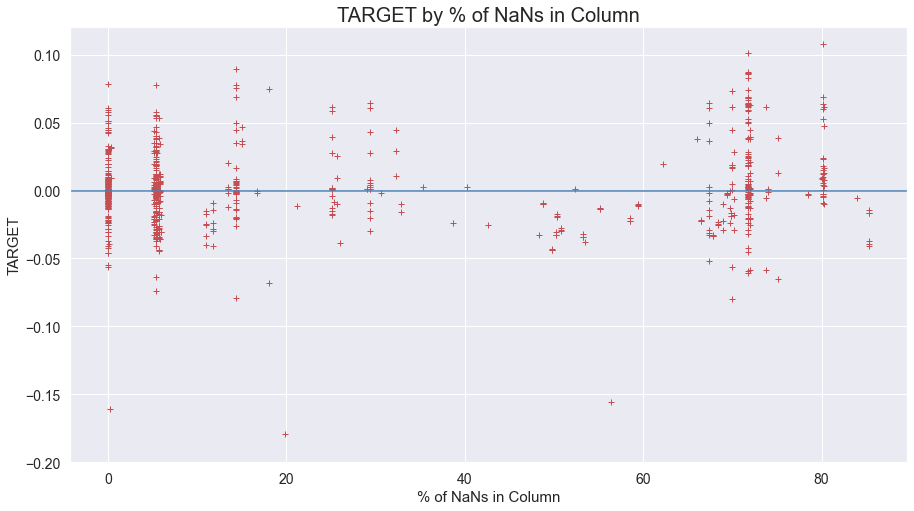

In [39]:
# Display correlation with TARGET by % of NaNs in each Column
sns.set_theme()
plt.figure(figsize=(15,8))
plt.plot(nans_df['% of NaNs in Column'], nans_df['TARGET'], "r+")
plt.axhline(y = 0, color = 'steelblue')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.xlabel("% of NaNs in Column", size = 15)
plt.ylabel("TARGET", size = 15)
plt.title("TARGET by % of NaNs in Column", size = 20)
plt.ylim(bottom = -0.2, top = 0.12)
plt.show()

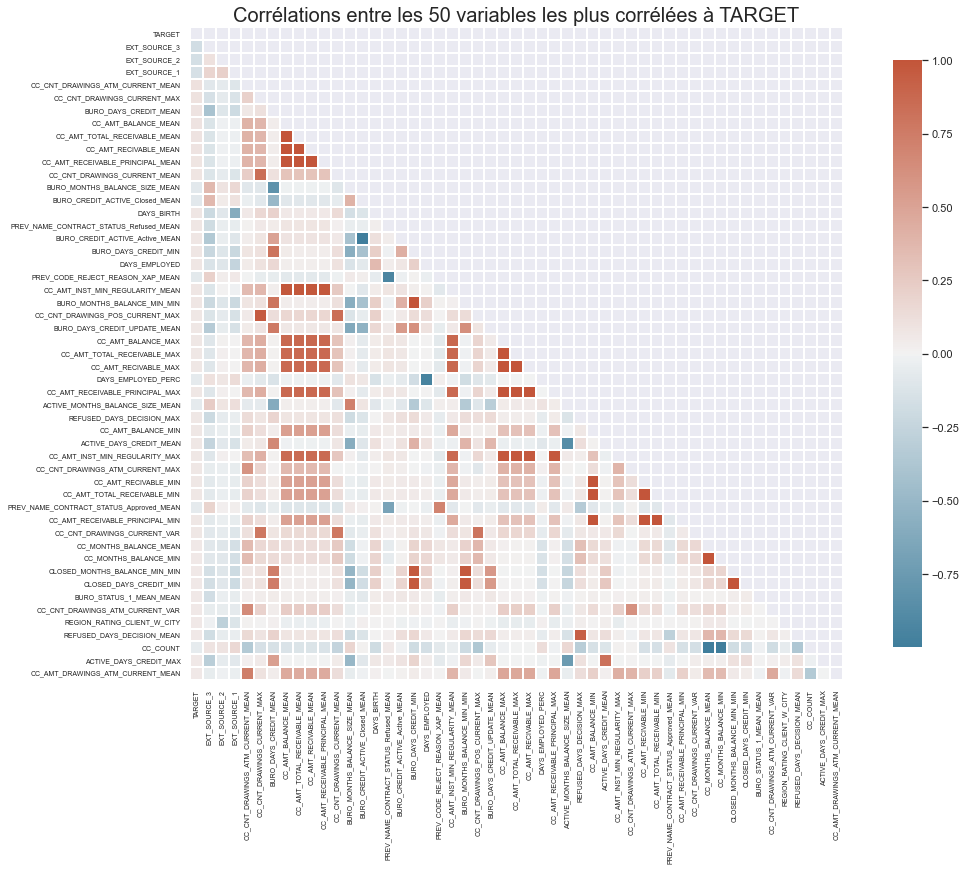

In [40]:
# View the correlation between the 50 most correlated features with TARGET

# Create the list of the 50 most correlated features with TARGET
list_most_correlated_feat = data_corr.sort_values(by = 'absTARGET', ascending = False).head(51).index.tolist()
# Create the dataframe with the 50 most correlated features
data_50_most_corr = train_df[list_most_correlated_feat]
# compute the correlation matrix
corr = data_50_most_corr[list_most_correlated_feat].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18,12))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
colormap = sns.heatmap(corr, 
                       annot=False,
                       mask=mask, 
                       cmap=cmap, 
                       vmax=1, 
                       center=0,
                       square=True, 
                       linewidths=2, 
                       cbar_kws={"shrink": .9})
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 7, rotation = 90)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 7)

plt.title('Corrélations entre les 50 variables les plus corrélées à TARGET', size = 20);

### Dataframe without columns with more than 40% of NaN

In [53]:
# Create a list of features with more than 40% of NaN
list_feat_nan40 = nans_df.loc[nans_df['% of NaNs in Column'] >= 40]['Column'].values.tolist()
len(list_feat_nan40)

245

In [54]:
# Create a dataframe without features with more than 40% of NaN
train_df_nan_40 = train_df.drop(list_feat_nan40, axis = 1)
train_df_nan_40

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,...,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.000000,1.000000,1.000000,NaN,0.00,0.0,0.00,179055.00,179055.0,179055.000,9.0,9.0,9.000000,0.000000,0.000000,0.000000,-606.0,-606.0,-606.000000,24.000000,24.0,-1.0,-10.000000,19.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,19.0,2.0,0.0,0.000000,0.0,31.0,20.421053,388.0,1.00000,1.000000,19.000000,0.000000,0.000,0.000000,0.000,0.000000e+00,53093.745,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.622246,NaN,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.868825,1.011109,0.949329,0.005324,0.00,6885.0,3442.50,68809.50,9

### Fill NaN with median values

In [52]:
train_df_nan40

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,...,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.000000,1.000000,1.000000,NaN,0.00,0.0,0.00,179055.00,179055.0,179055.000,9.0,9.0,9.000000,0.000000,0.000000,0.000000,-606.0,-606.0,-606.000000,24.000000,24.0,-1.0,-10.000000,19.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,19.0,2.0,0.0,0.000000,0.0,31.0,20.421053,388.0,1.00000,1.000000,19.000000,0.000000,0.000,0.000000,0.000,0.000000e+00,53093.745,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.622246,NaN,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.868825,1.011109,0.949329,0.005324,0.00,6885.0,3442.50,68809.50,9

In [56]:
# Replace NaN by median in train_df_nan40

# Create SimpleImputer with 'median' strategy
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'median')

# Fit to 'train_df_nan40', then transform it
train_df_nan40 = pd.DataFrame(imp_mean.fit_transform(train_df_nan_40))
train_df_nan40.columns = train_df_nan_40.columns
train_df_nan40.index = train_df_nan_40.index

In [59]:
# Check that there is no more NaN in the dataframe
train_df_nan40.isna().sum().sum()

0

In [60]:
# Save train_df_nan40 as csv file
train_df_nan40.to_csv('train_df_nan40.csv', index = False)